In [1]:
import os

PROJECTPATH = r"C:\Users\mahesj1\Desktop\InternshipWork_2324\Data"
DATAPATH = PROJECTPATH
CODEPATH = PROJECTPATH
RESULTPATH = os.path.join(PROJECTPATH, "fraudTrain.csv")

print(PROJECTPATH)
print(DATAPATH)
print(CODEPATH)
print(RESULTPATH)

C:\Users\mahesj1\Desktop\InternshipWork_2324\Data
C:\Users\mahesj1\Desktop\InternshipWork_2324\Data
C:\Users\mahesj1\Desktop\InternshipWork_2324\Data
C:\Users\mahesj1\Desktop\InternshipWork_2324\Data\fraudTrain.csv


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from imblearn.over_sampling import SMOTE
from statistics import mean

# Read the dataset into a DataFrame
df = pd.read_csv(RESULTPATH)
df.head()


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [3]:
#Hyperparameters to be tuned: max_features, min_samples_split, min_samples_leaf, criterion, max_depth
#Features to be trained on: 'cc_num', 'merchant', 'category','amt', 'gender', 'street', 'city', 'state', 'zip',
#'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time','merch_lat', 'merch_long', 'is_fraud'

#How to train on categorical variables like job, merchant, and category (one hot encodings?)
#How to create age from DOB in years - I tried to use the current year and subtract last 4 digits for new column
print(df.columns)


Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')


In [4]:
gender_mapping = {'M': 0, 'F': 1}
df['numGender'] = df['gender'].map(gender_mapping)

In [5]:
from datetime import datetime

df['dob'] = pd.to_datetime(df['dob'])

# Calculate age in years
current_date = datetime.now()
df['ageInYears'] = ((current_date - df['dob']).dt.days / 365.25).astype(int)  # found online
df.head()


,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,numGender,ageInYears
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0,1,36
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0,1,45
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0,0,62
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0,0,57
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0,0,38


In [6]:
features = ['amt', 'numGender','lat', 'long', 'city_pop', 'ageInYears', 'unix_time','merch_lat', 'merch_long']
target = 'is_fraud'

In [ ]:
X_train = df[features]
y_train = df[target]

In [ ]:
# Cross-validation 
num_folds = 5
np.random.seed(42)
N = X_train.shape[0]
index = [0, int((N-1)/5), int(2*(N-1)/5), int(3*(N-1)/5), int(4*(N-1)/5), N-1]

n_estimators = [10, 50, 100, 150, 200]
max_depth = [None, 5, 10, 15, 20]
min_samples_split = [2, 3, 4, 5, 10, 50, 100]
max_features = [None, 'sqrt', 'log2']


In [ ]:
models_with_metrics = []

for l in n_estimators:
    for j in max_depth:
        for k in min_samples_split:
            for m in max_features: 
                
                precision_list = []
                recall_list = []

                for i in range(num_folds):
                    model = RandomForestClassifier(n_estimators=l, max_depth=j, min_samples_split=k, max_features=m)
                    validation_set = X_train.iloc[index[i]:index[i+1]]
                    y_validation_set = y_train.iloc[index[i]:index[i+1]]

                    if i == 0:
                        training_set = X_train.iloc[index[i+1]:]
                        y_training_set = y_train.iloc[index[i+1]:]
                    elif i == num_folds - 1:
                        training_set = X_train.iloc[:index[i]]
                        y_training_set = y_train.iloc[:index[i]]
                    else:
                        training_set = pd.concat([X_train.iloc[:index[i]], X_train.iloc[index[i+1]:]])
                        y_training_set = pd.concat([y_train.iloc[:index[i]], y_train.iloc[index[i+1]:]])
                    
                    model.fit(training_set, y_training_set)
                    y_pred = model.predict(validation_set)
                    precision = precision_score(y_validation_set, y_pred)
                    recall = recall_score(y_validation_set, y_pred)
                    precision_list.append(precision)
                    recall_list.append(recall)

                avg_precision = mean(precision_list)
                avg_recall = mean(recall_list)

                models_with_metrics.append({
                    'model': model,
                    'precision': avg_precision,
                    'recall': avg_recall,
                    'n_estimators': l,
                    'max_depth': j,
                    'min_samples_split': k,
                    'max_features': m
                })
                
                print(f"max_features={m}, n_estimators={l}, max_depth={j}, min_samples_split={k}")


sorted_models = sorted(models_with_metrics, key=lambda m: m['precision'])
bottom_10_models = sorted_models[:10]
top_10_models = sorted_models[-10:]

In [7]:
print(len(df['amt']))
print(len(df['is_fraud']))

        

1296675
1296675


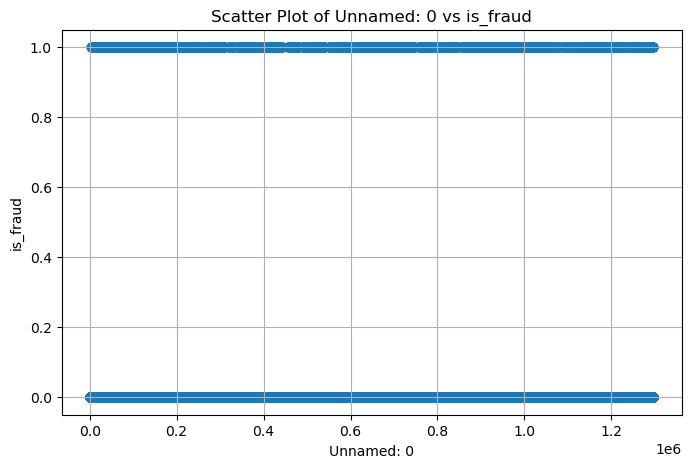

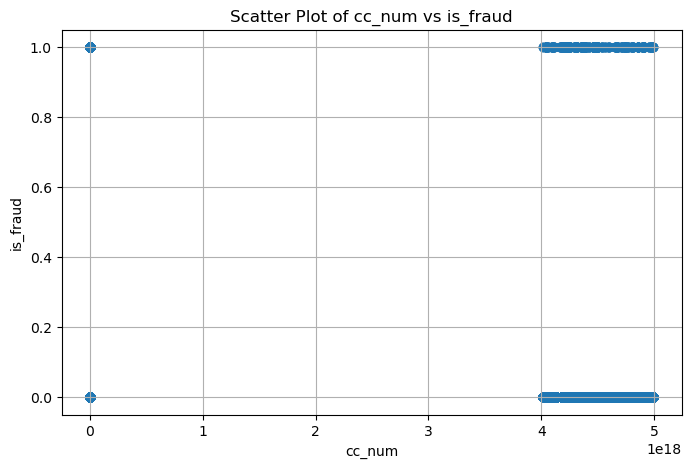

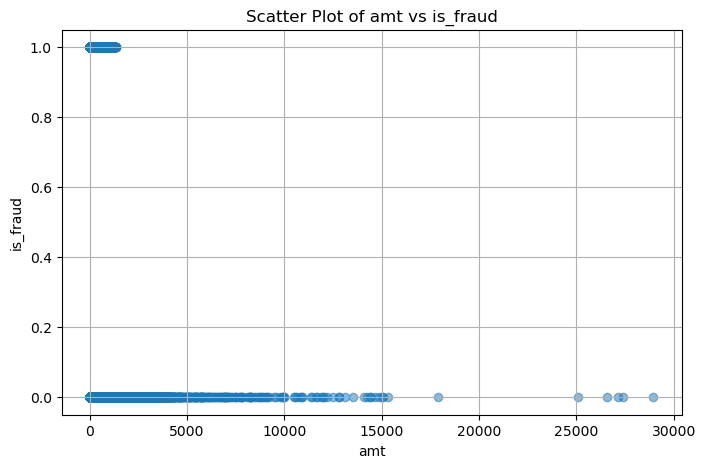

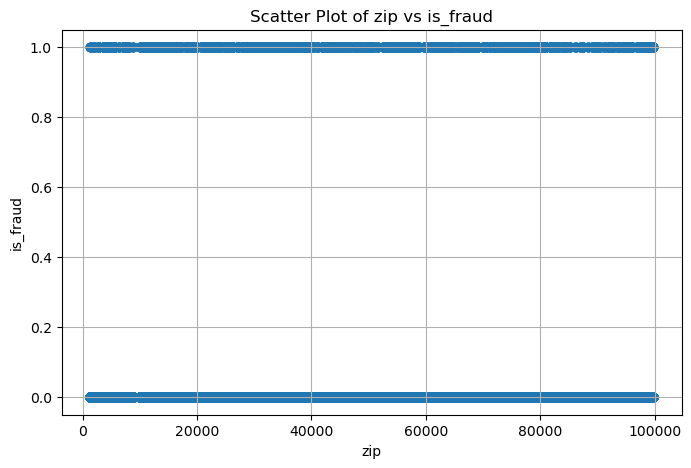

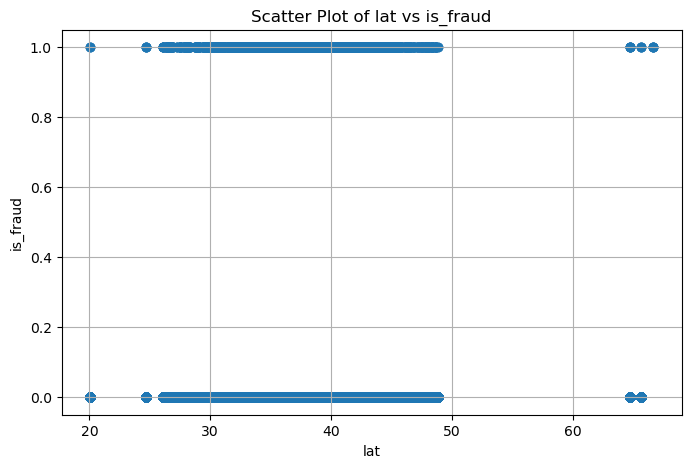

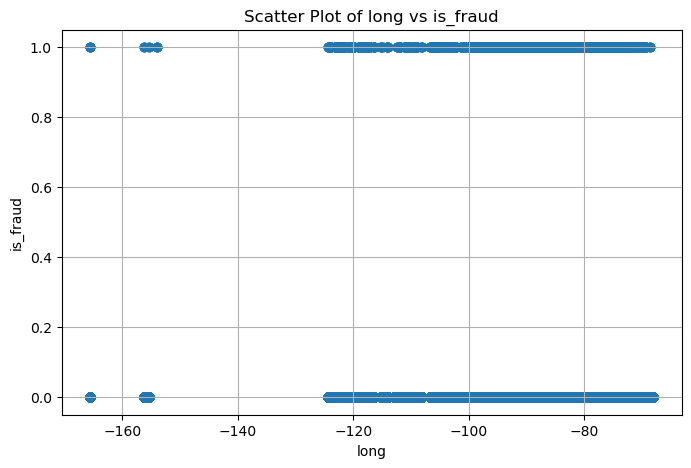

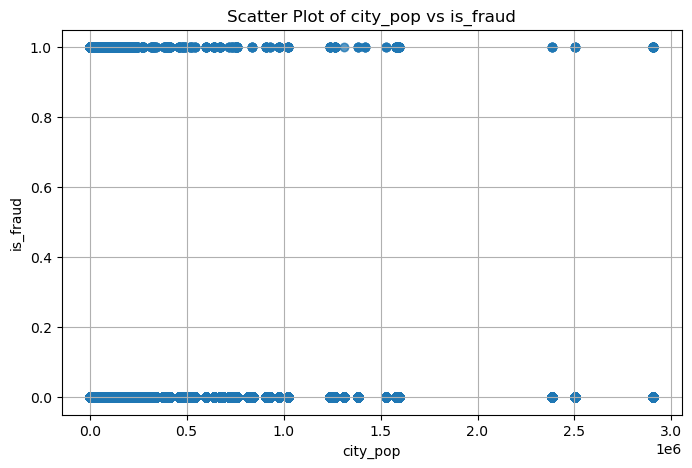

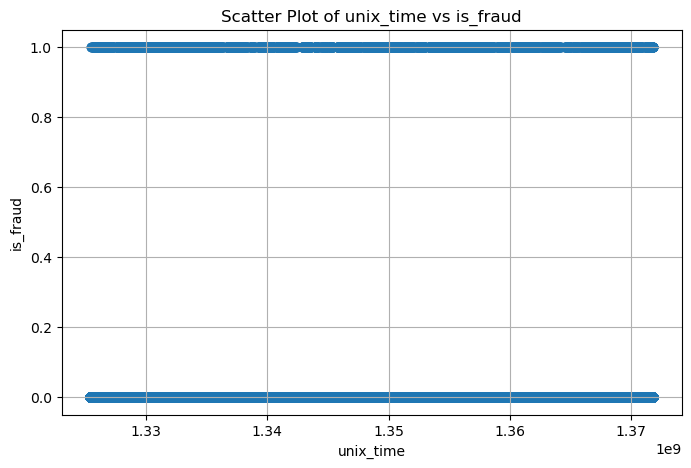

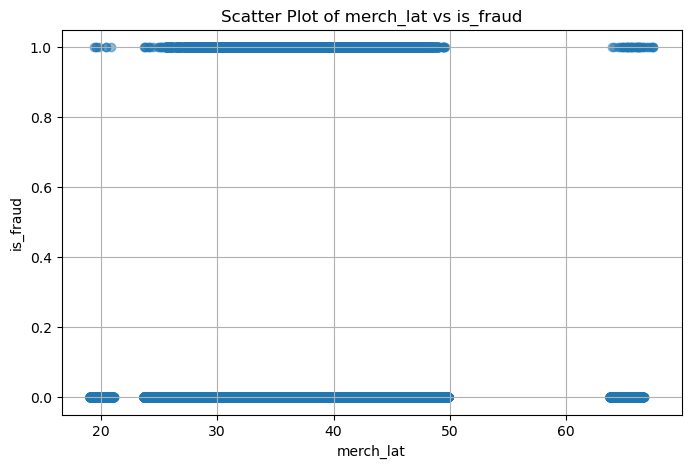

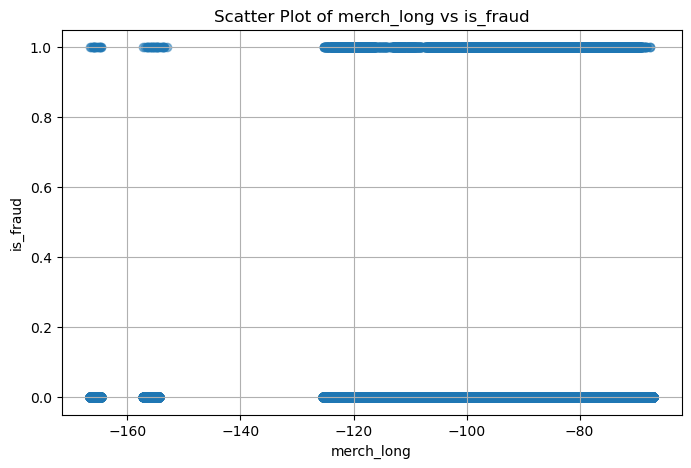

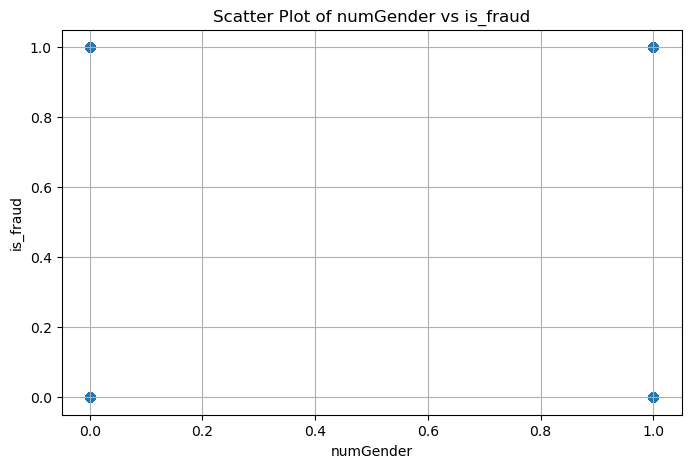

In [6]:
import matplotlib.pyplot as plt

for column in df.columns:
    if df[column].dtype in ['int64', 'float64'] and column != 'is_fraud':
        plt.figure(figsize=(8, 5)) 
        plt.scatter(df[column], df['is_fraud'], alpha=0.5) 
        plt.title(f'Scatter Plot of {column} vs is_fraud')  
        plt.xlabel(column) 
        plt.ylabel('is_fraud') 
        plt.grid(True) 
        plt.show()

In [7]:
for column in df.columns:
    if df[column].dtype in ['String'] and column != 'is_fraud':
        plt.figure(figsize=(8, 5)) 
        plt.bar(df[column], df['is_fraud'], alpha=0.5) 
        plt.title(f'Bar plot of {column} vs is_fraud')  
        plt.xlabel(column) 
        plt.ylabel('is_fraud') 
        plt.grid(True) 
        plt.show()